In [1]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hits = []
for i in range(1, 23):
    hits.extend(json.load(open(f"/home/jpivarski/storage/data/physicists/chep-papers/chep-papers-{i}.json"))["hits"]["hits"])

In [3]:
cnums = {
    "C85-06-25": 1,   # CHEP 1 in 1985
    "C87-02-02.2": 2,
    "C89-04-10": 3,
    "C90-04-09": 4,
    "C90-09-04": 4,   # duplicate
    "C91-03-11": 5,
    "C92-09-21": 6,
    "C94-04-21": 7,
    "C95-09-18": 8,
    "C97-04-07": 9,
    "C98-08-31": 10,
    "C00-02-07": 11,
    "C00-07-02": 11,   # duplicate
    "C01-09-03.1": 12,
    "C03-03-24.1": 13,
    "C04-09-27": 14,
    "C06-02-13": 15,   # this one was tiny; skews statistics
    "C07-09-02.1": 16,
    "C09-03-21": 17,
    "C10-10-18.4": 18,
    "C12-05-21.3": 19,
    "C13-10-14.1": 20,
    "C15-04-13": 21,
    "C16-10-14": 22,
    "C18-07-09.6": 23,
    "C19-11-04": 24,
    "C21-05-17.1": 25,  # CHEP 25 in 2020
}
years = ["'85", "'87", "'89", "'90", "'91", "'92", "'94", "'95", "'97", "'98", "'00", "'01", "'03", "'04", "'06", "'07", "'09", "'10", "'12", "'13", "'15", "'16", "'18", "'19", "'21"]

In [4]:
words = [
    r"analysis",
    r"simulation",
    r"reconstruction",
    r"trigger",
    r"(acquisition|\bDAQ\b)",
    r"(lattice|\bLQCD\b)",

    r"(machine[- ]learn|\bML\b)",
    r"(neural|\bNN\b)",
    r"deep[- ]learn",
    r"(boosted[- ]decision|\bBDT\b)",

    r"tool",
    r"framework",
    r"distributed",
    r"parallel",
    r"concurren",
    r"interactive",
    r"collaborative",
    r"preserv",
    r"query",

    r"FORTRAN",
    r"C\+\+",
    r"Java",
    r"Python",
    r"\bAda\b",
    r"Pascal",

    r"(object[- ]orient|\bOOP?\b)",
    r"array",
    r"(functional[- ](prog|analy|lang|style|query|archi|interf)|purely functional|\bFP\b)",
    r"declarative",

    r"database",
    r"(web|\bWWW\b)",
    r"(UNIX|Linux)",
    r"\bXML\b",
    r"\bJSON\b",

    r"\bROOT\b",
    r"\b(Objectivity|ORM|OODB(|MS))\b",
    r"\b(Hippoplotamus|HippoDraw)\b",
    r"\b(Java Analysis Studio|JAS|Jas4pp|FreeHEP)\b",
    r"\bPROOF\b",
    r"\b([RT]DataFrame|RDF)\b",
    r"\b(Uproot|Coffea|Scikit-HEP)\b",

    r"\bCPUs?\b",
    r"\b(GPUs?|CUDA)\b",
    r"\b(FPGAs?|V?HDL|Verilog)\b",
    r"\bTPUs?\b",
    r"\bRISCs?\b",
    
    r"columnar",
    r"\bLHC\+\+",
    r"Julia",
]

In [5]:
counters = {word: [0] * 25 for word in words}
pairs = [(word, re.compile(word, re.I)) if word != r"\bPROOF\b" else (word, re.compile(word)) for word in words]
denoms = [0] * 25

for hit in hits:
    cnum = None
    for pubinfo in hit["metadata"]["publication_info"]:
        cnum = pubinfo.get("cnum")
        if cnum in cnums:
            break
    denoms[cnums[cnum] - 1] += 1
    for word, regex in pairs:
        in_title = any(regex.search(title["title"]) is not None for title in hit["metadata"].get("titles", []))
        in_abstract = any(regex.search(abstract["value"]) is not None for abstract in hit["metadata"].get("abstracts", []))
        if in_title or in_abstract:
            counters[word][cnums[cnum] - 1] += 1

In [6]:
def plot(which, counters, denoms, **special):
    index = pd.Index(range(1, 26), name="CHEP")
    df = pd.DataFrame({x if x != r"\bPROOF\b" else x + " (case-sensitive)": counters[x] for x in counters if x in which}, index=index)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

    df.div(0.01 * pd.Series(denoms, index=index), axis=0).plot(ax=ax, **special)
    ax.set_xlim(1, 25)
    ax.set_ylim(bottom=0)
    ax2 = ax.twiny()
    ax2.set_xticks(range(0, 25))
    ax2.set_xticklabels(years)
    ax2.set_xlabel("year")
    ax.set_xticks(range(1, 26))
    ax.set_ylabel("percent of talks with matching title/abstract")
    ax.set_xlabel("CHEP number")
    ax.tick_params(labelleft=True, labelright=True)
    
    return ax

In [7]:
plt.rcParams.update({"figure.facecolor": (1, 1, 1, 1)})

In [8]:
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = plt.rcParams["axes.prop_cycle"].by_key()["color"]

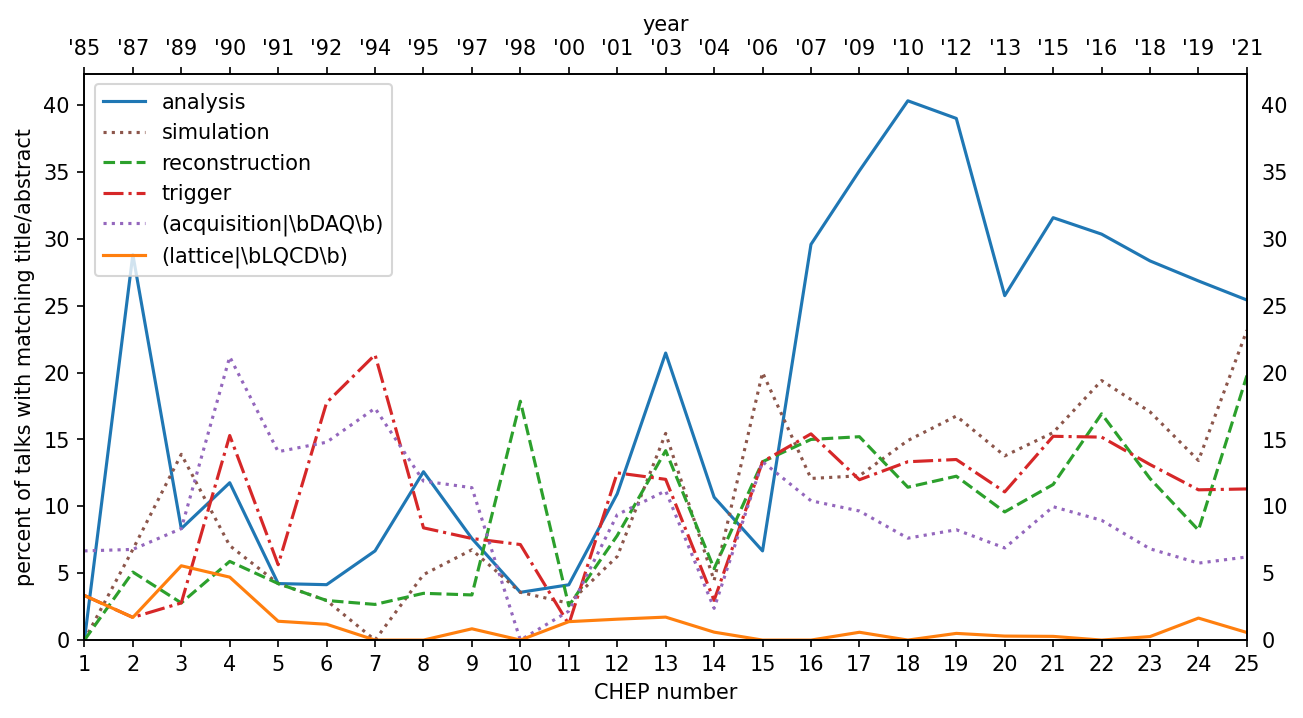

In [9]:
plot(words[0:6], counters, denoms, style=["-", ":", "--", "-.", ":", "-"], color=[c1, c6, c3, c4, c5, c2])
plt.savefig("PLOTS/chep-papers-task.svg")
plt.savefig("PLOTS/chep-papers-task.pdf")

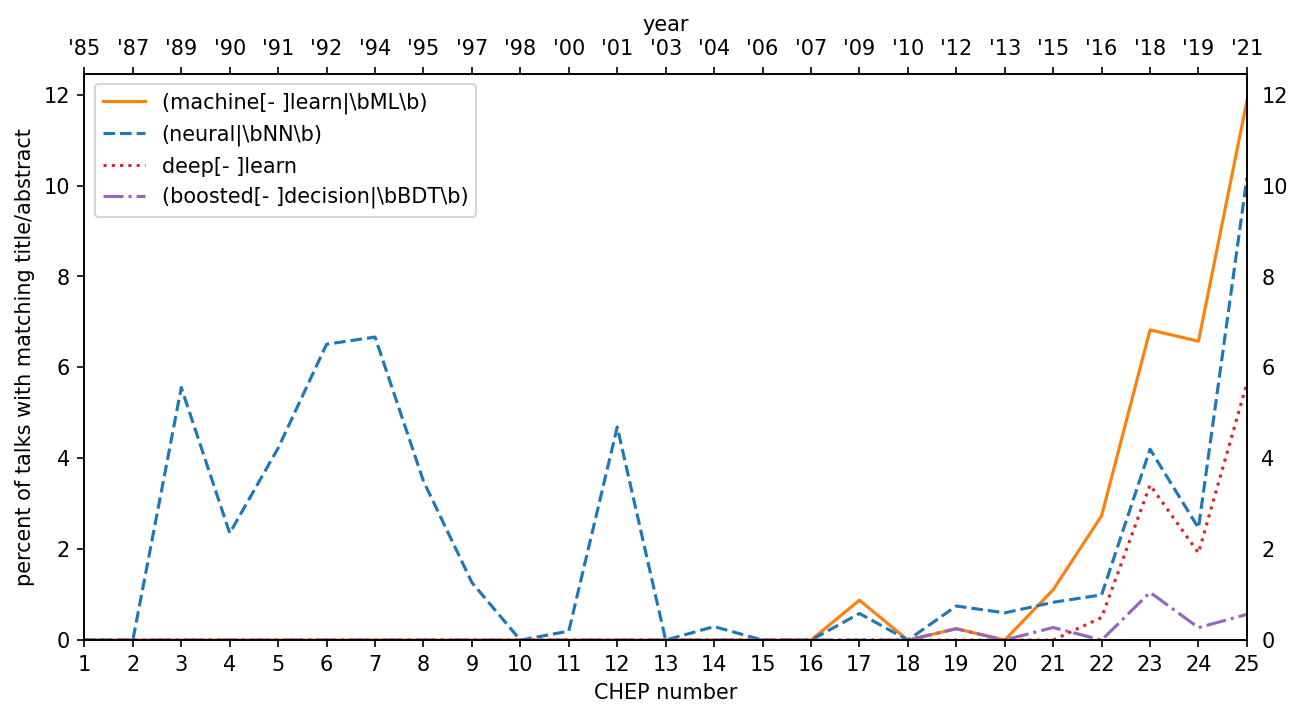

In [10]:
plot(words[6:10], counters, denoms, style=["-", "--", ":", "-.", "-"], color=[c2, c1, c4, c5, c3])
plt.savefig("PLOTS/chep-papers-ml.svg")
plt.savefig("PLOTS/chep-papers-ml.pdf")

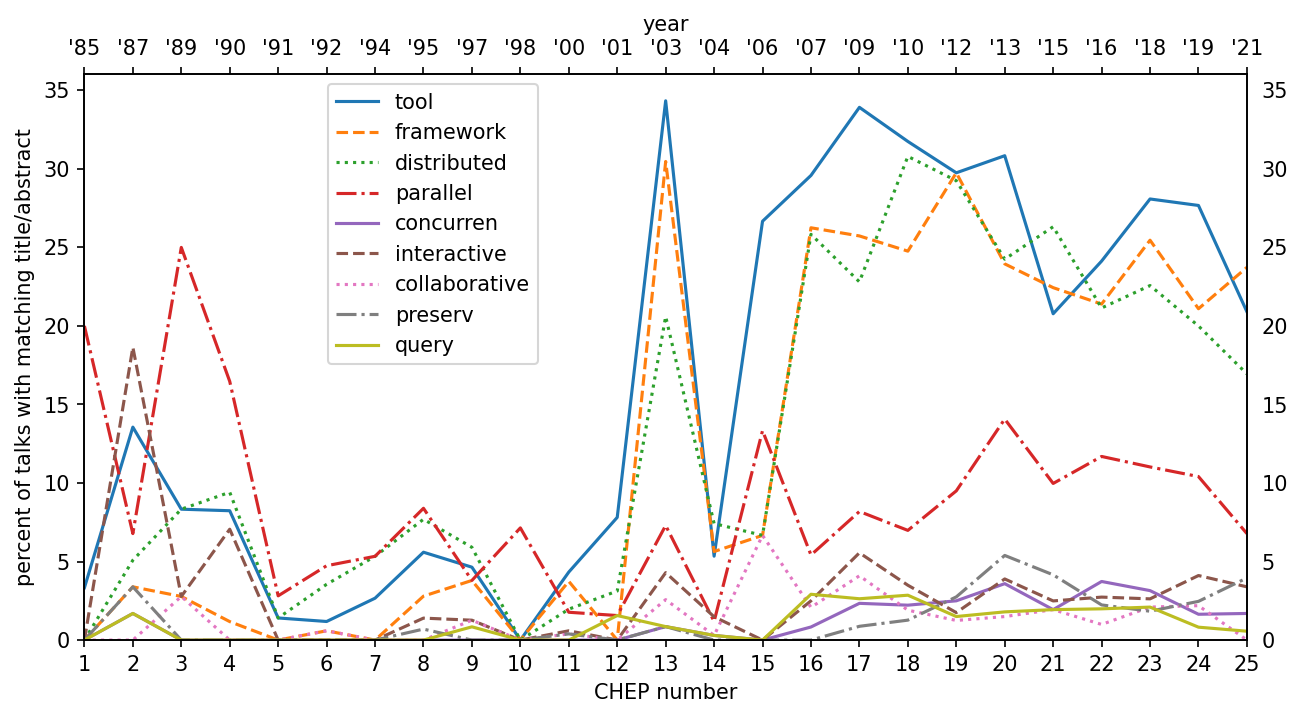

In [11]:
ax = plot(words[10:19], counters, denoms, style=["-", "--", ":", "-.", "-", "--", ":", "-.", "-"])
ax.legend(bbox_to_anchor=(0, 0, 0.6, 1))
plt.savefig("PLOTS/chep-papers-descriptor.svg")
plt.savefig("PLOTS/chep-papers-descriptor.pdf")

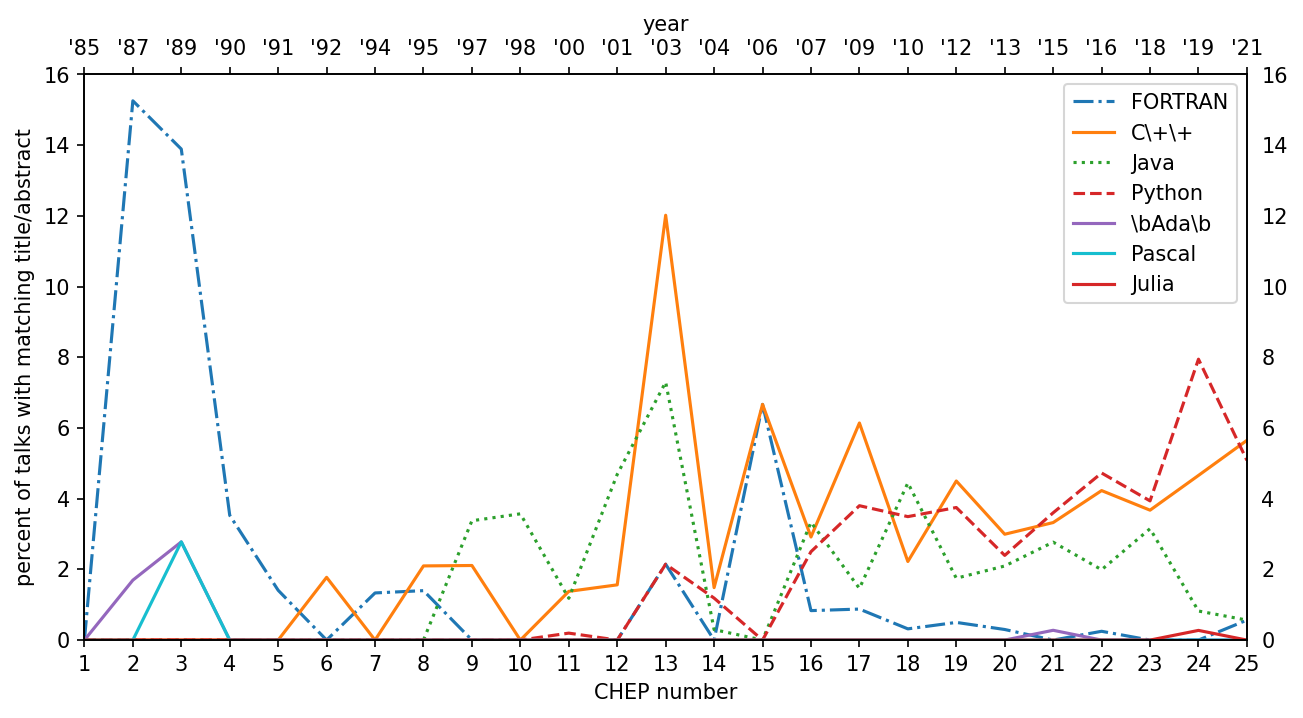

In [12]:
plot(words[19:25] + words[-1:], counters, denoms, style=["-.", "-", ":", "--", "-", "-", "-"], color=[c1, c2, c3, c4, c5, c10, c4])
plt.savefig("PLOTS/chep-papers-language.svg")
plt.savefig("PLOTS/chep-papers-language.pdf")

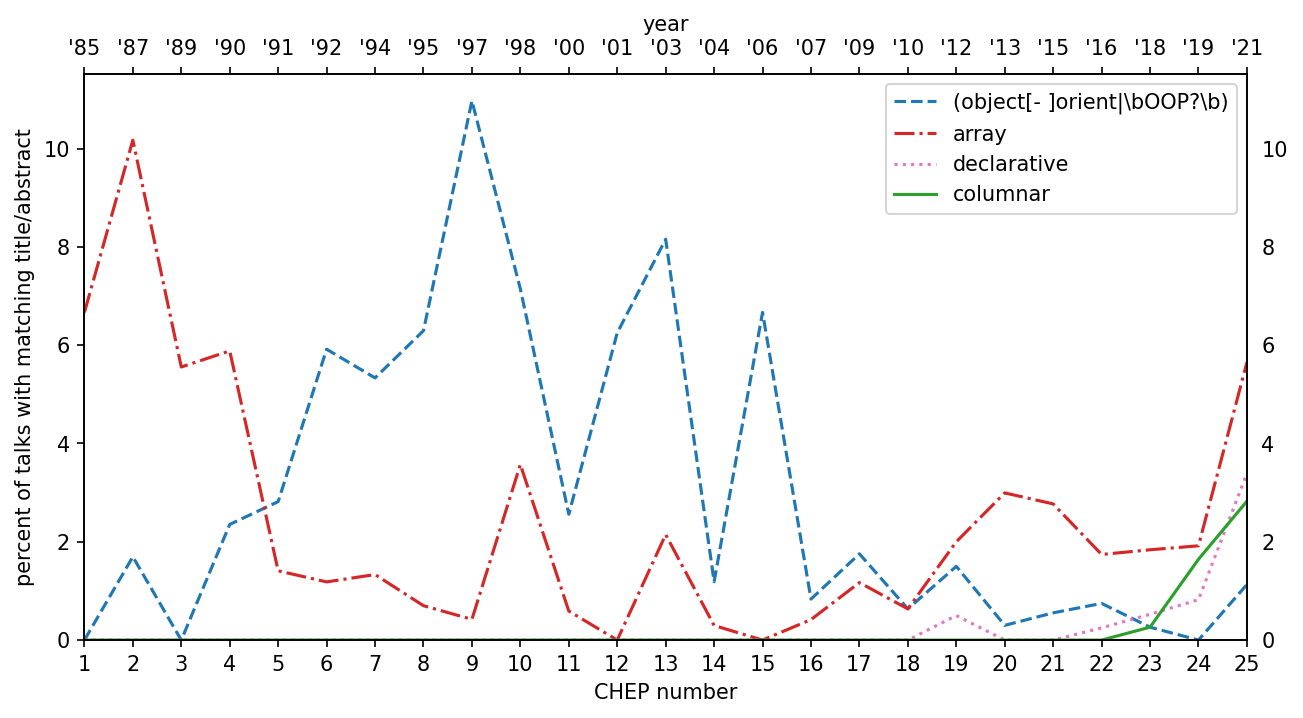

In [13]:
plot([words[25], words[26], words[28], words[-3]], counters, denoms, style=["--", "-.", ":", "-"], color=[c1, c4, c7, c3])
plt.savefig("PLOTS/chep-papers-paradigm.svg")
plt.savefig("PLOTS/chep-papers-paradigm.pdf")

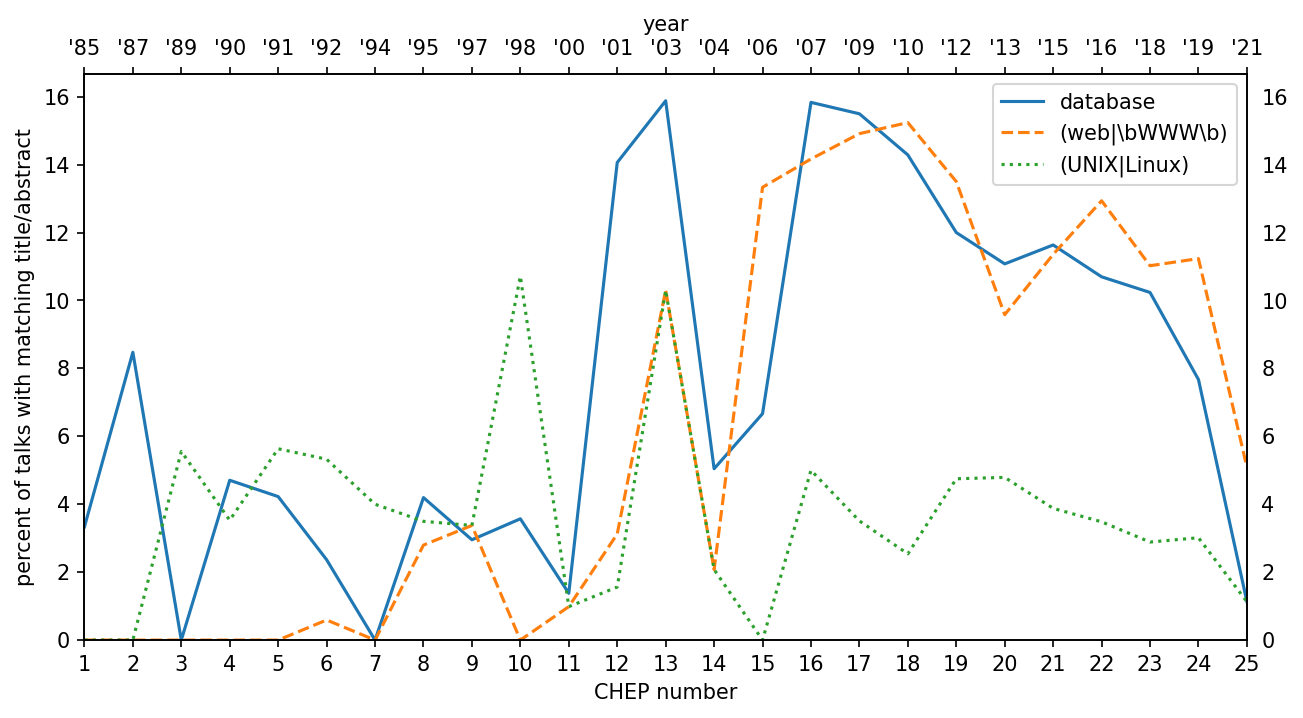

In [14]:
plot(words[29:32], counters, denoms, style=["-", "--", ":"], color=[c1, c2, c3])
plt.savefig("PLOTS/chep-papers-technology.svg")
plt.savefig("PLOTS/chep-papers-technology.pdf")

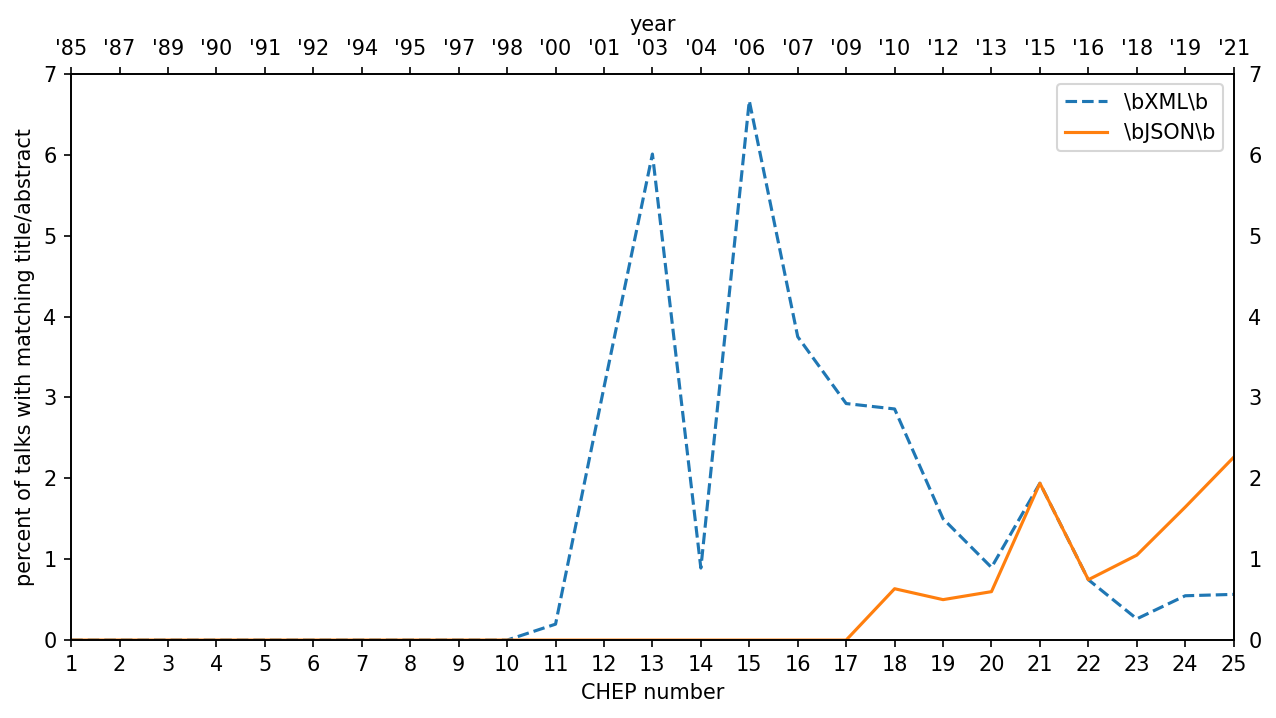

In [15]:
plot(words[32:34], counters, denoms, style=["--", "-"])
plt.savefig("PLOTS/chep-papers-textformat.svg")
plt.savefig("PLOTS/chep-papers-textformat.pdf")

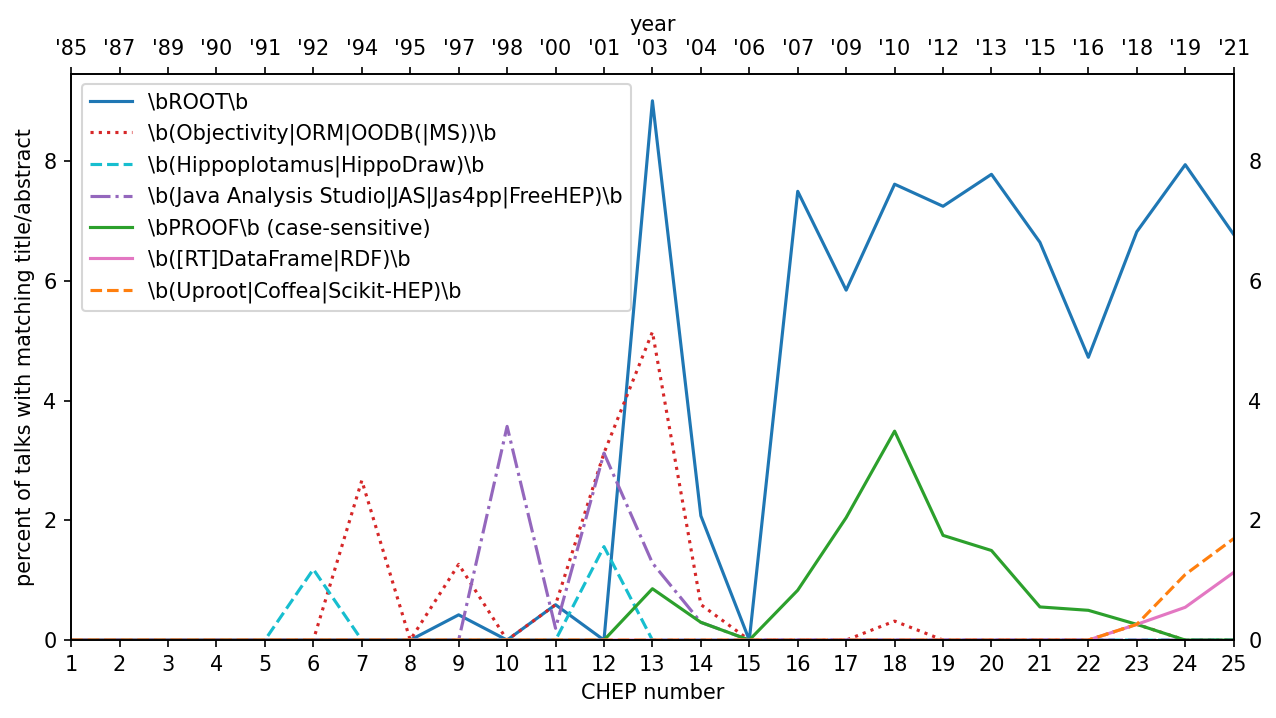

In [16]:
plot(words[34:41], counters, denoms, style=["-", ":", "--", "-.", "-", "-", "--"], color=[c1, c4, c10, c5, c3, c7, c2])
plt.savefig("PLOTS/chep-papers-package.svg")
plt.savefig("PLOTS/chep-papers-package.pdf")

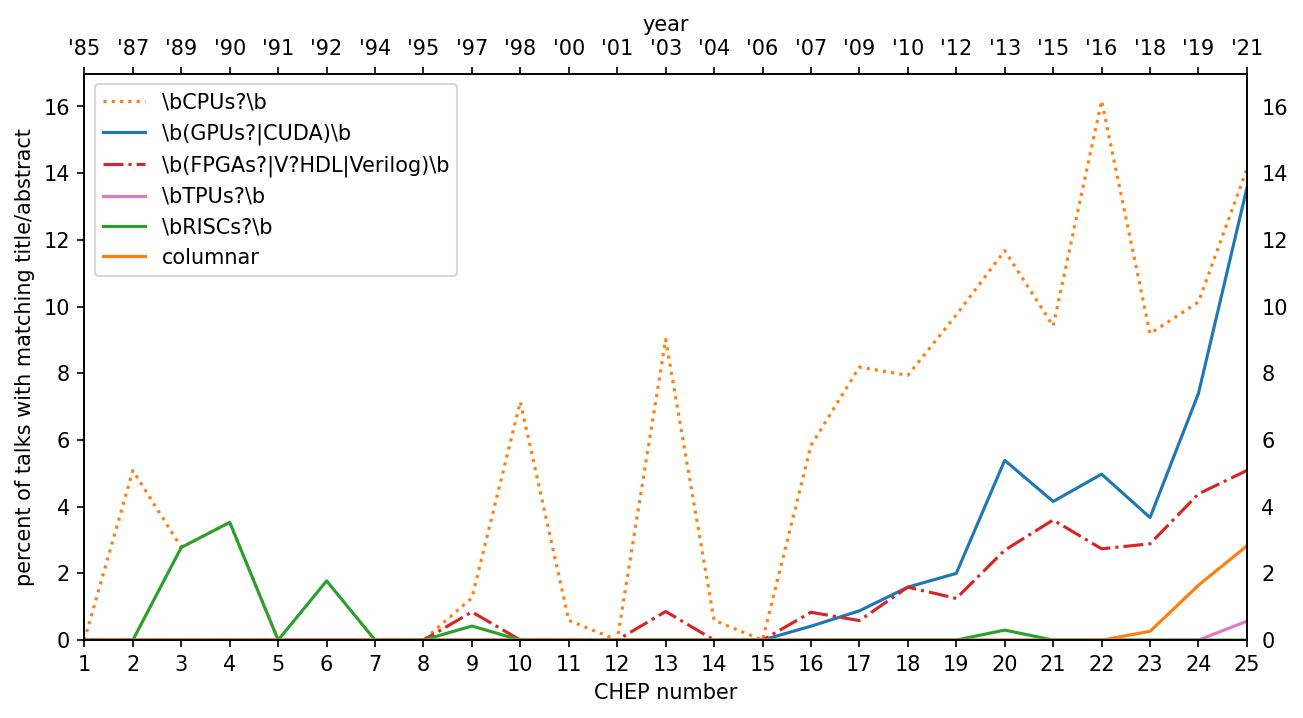

In [17]:
plot(words[41:47], counters, denoms, style=[":", "-", "-.", "-", "-"], color=[c2, c1, c4, c7, c3])
plt.savefig("PLOTS/chep-papers-accelerator.svg")
plt.savefig("PLOTS/chep-papers-accelerator.pdf")

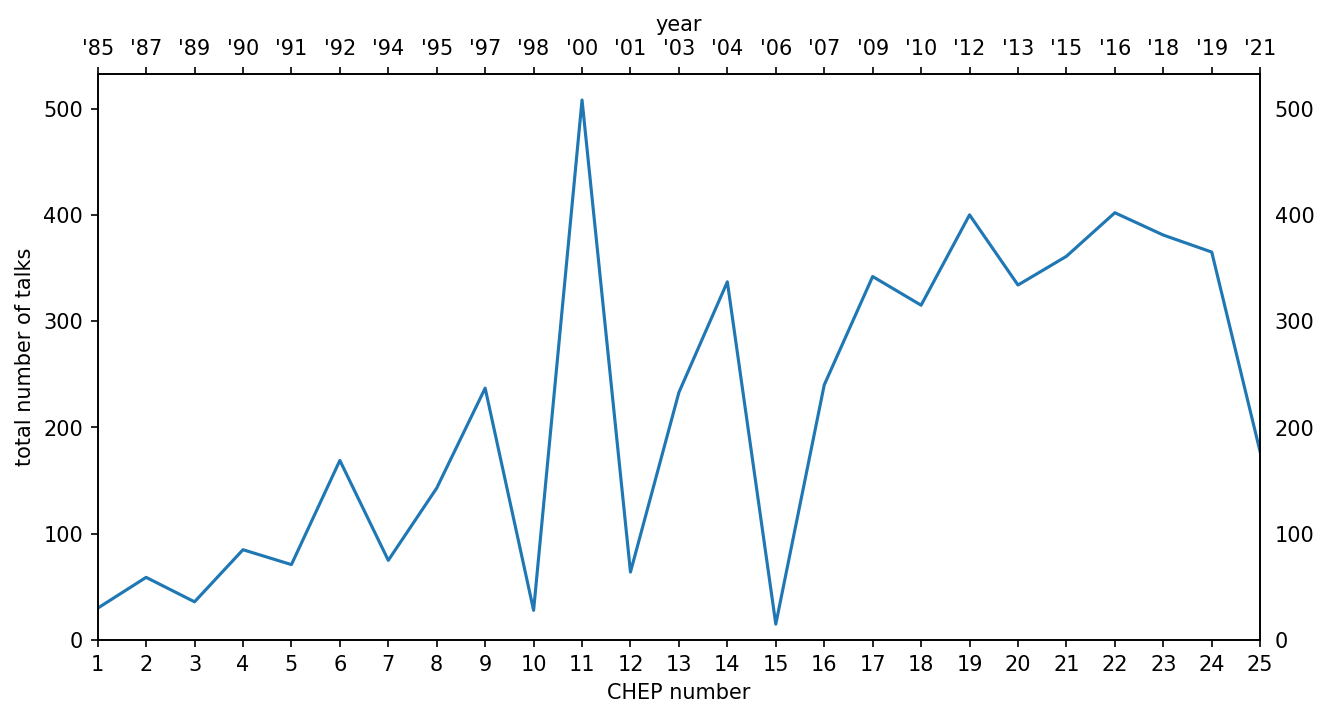

In [18]:
index = pd.Index(range(1, 26), name="CHEP")

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

pd.Series(denoms, index=index).plot(ax=ax)
ax.set_xlim(1, 25)
ax.set_ylim(bottom=0)
ax2 = ax.twiny()
ax2.set_xticks(range(0, 25))
ax2.set_xticklabels(years)
ax2.set_xlabel("year")
ax.set_xticks(range(1, 26))
ax.set_ylabel("total number of talks")
ax.set_xlabel("CHEP number")
ax.tick_params(labelleft=True, labelright=True)

plt.savefig("PLOTS/chep-papers-denominator.svg")
plt.savefig("PLOTS/chep-papers-denominator.pdf")

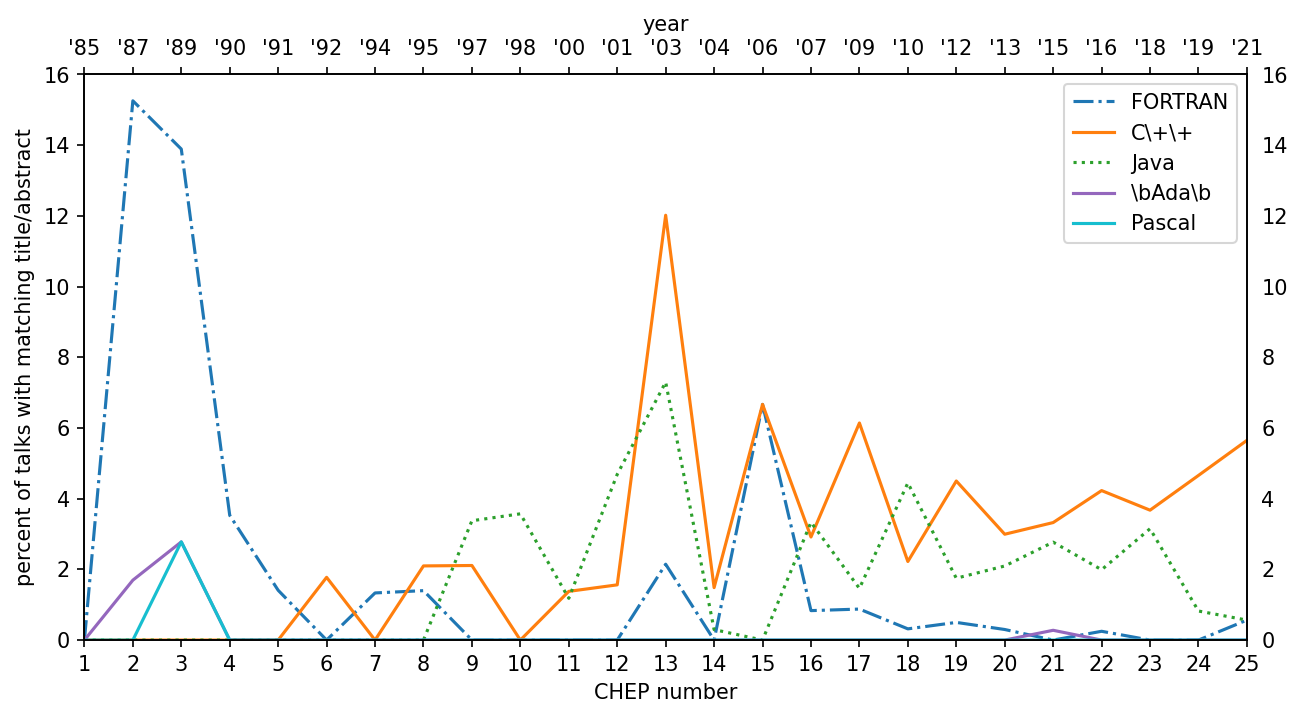

In [19]:
plot(words[19:22] + words[23:25], counters, denoms, style=["-.", "-", ":", "-", "-"], color=[c1, c2, c3, c5, c10, c4])
plt.savefig("PLOTS/chep-papers-language-1.svg")
plt.savefig("PLOTS/chep-papers-language-1.pdf")

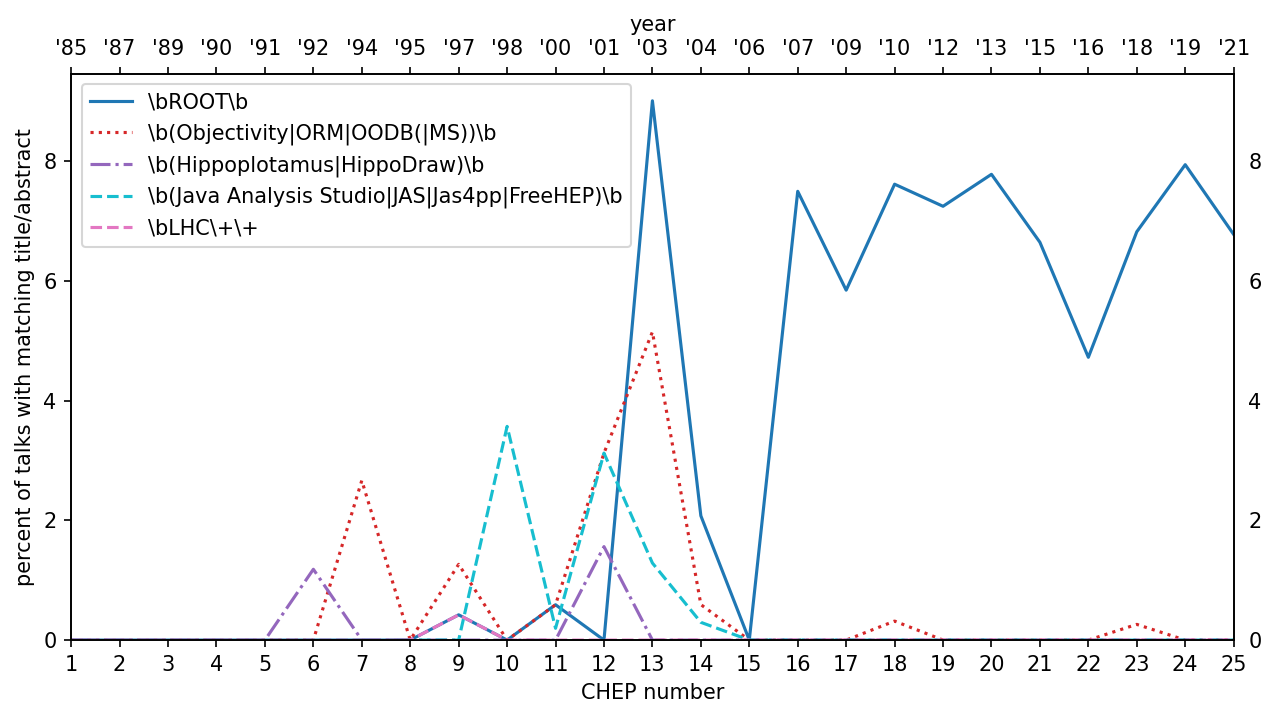

In [20]:
plot([words[34], words[35], words[37], words[36], words[-2]], counters, denoms, style=["-", ":", "-.", "--", "--"], color=[c1, c4, c5, c10, c7])
plt.savefig("PLOTS/chep-papers-package-1.svg")
plt.savefig("PLOTS/chep-papers-package-1.pdf")

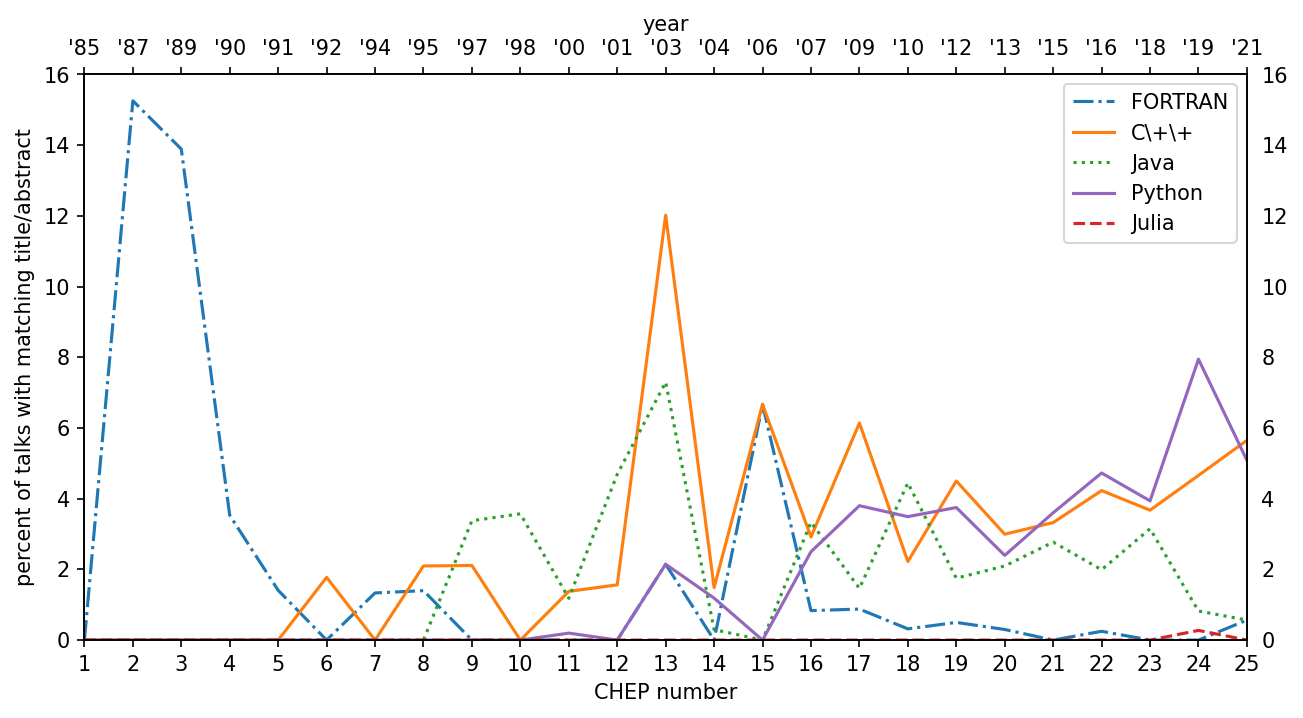

In [21]:
plot(words[19:23] + words[-1:], counters, denoms, style=["-.", "-", ":", "-", "--"], color=[c1, c2, c3, c5, c4])
plt.savefig("PLOTS/chep-papers-language-2.svg")
plt.savefig("PLOTS/chep-papers-language-2.pdf")

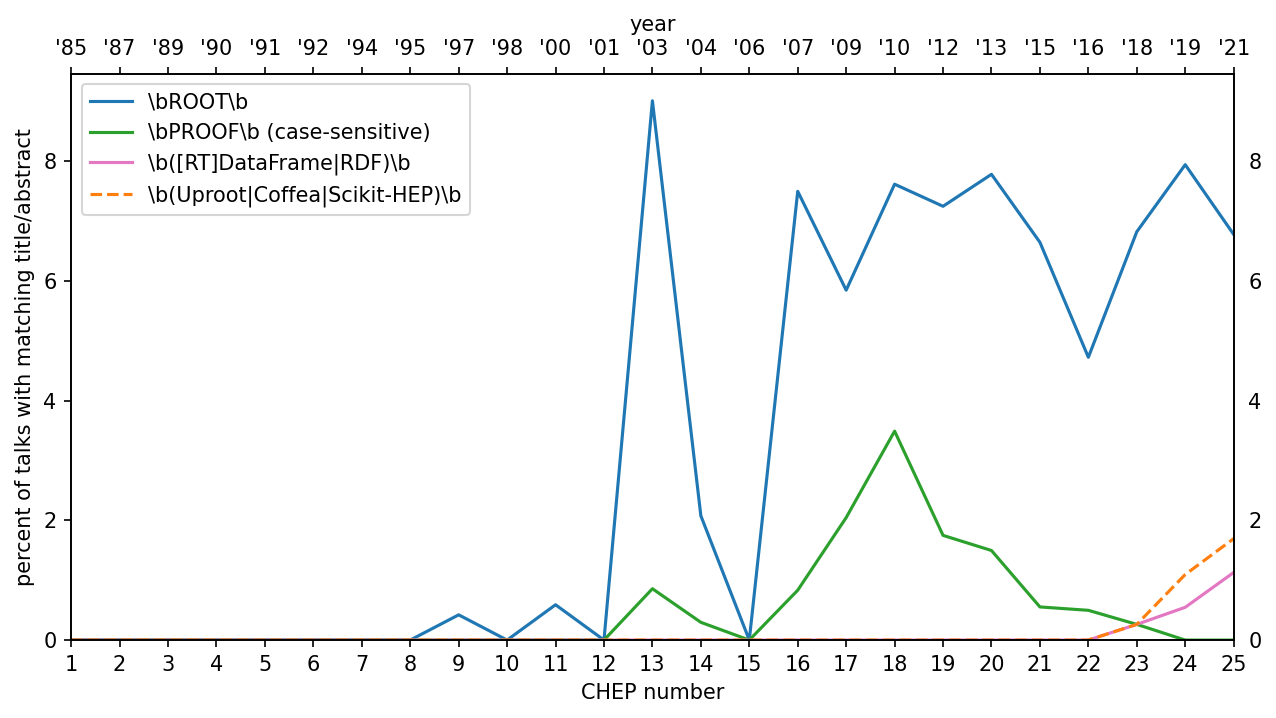

In [22]:
plot([words[34], words[38], words[39], words[40]], counters, denoms, style=["-", "-", "-", "--"], color=[c1, c3, c7, c2])
plt.savefig("PLOTS/chep-papers-package-2.svg")
plt.savefig("PLOTS/chep-papers-package-2.pdf")